In [2]:
import time
import eli5
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display # Allows the use of display() for DataFrames
from pprint import pprint
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.feature_extraction.text import *
from sklearn.feature_selection import *
from sklearn.model_selection import *
from sklearn.calibration import CalibratedClassifierCV

# Import models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

# Pretty display for notebooks
%matplotlib inline

In [3]:
# Load the prescription text dataset
xlsx_file = "Dosage Parser extract - All strings - 14-08-18.xlsx"
data = pd.read_excel(xlsx_file, sheetname="WORKINGCOPY_2018_8_14_14_21_22")

# Display the first few records
display(data.head(n=5))
data.shape

,DosageString,Abbreviation,Occurances,Quantity,Frequency,Status
0,NaN,NaN,105,NaN,NaN,Unparsed
1,"""1 EVERY DAY FOR BLOOD PRESSURE AND THE HEART,...",1OD,n/a,1.0,1.0,Active
2,"""1 EVERY NIGHT """" FOR CHOLESTEROL""""""",1OD,n/a,1.0,1.0,Active
3,"""TAKE ONE DAILY ,""",1OD,n/a,1.0,1.0,Active
4,"""TAKE ONE DAILY, TO CONTROL BLOOD PRESSURE""",1OD,n/a,1.0,1.0,Active


(8661, 6)

## Data Filtering and Cleaning

In [4]:
#drop unparsed records
filtered_df = data[data.Status != 'Unparsed']

# Display the first few records
display(filtered_df.head(n=5))
filtered_df.shape

,DosageString,Abbreviation,Occurances,Quantity,Frequency,Status
1,"""1 EVERY DAY FOR BLOOD PRESSURE AND THE HEART,...",1OD,n/a,1.0,1.0,Active
2,"""1 EVERY NIGHT """" FOR CHOLESTEROL""""""",1OD,n/a,1.0,1.0,Active
3,"""TAKE ONE DAILY ,""",1OD,n/a,1.0,1.0,Active
4,"""TAKE ONE DAILY, TO CONTROL BLOOD PRESSURE""",1OD,n/a,1.0,1.0,Active
5,"""TAKE ONE DAILY,""",1OD,n/a,1.0,1.0,Active


(3680, 6)

In [5]:
#id is easier to deal with than floats as categorical

#Add id for Quantity classes
filtered_df['quant_id'] = filtered_df['Quantity'].factorize()[0]
quant_id_df = filtered_df[['Quantity', 'quant_id']].drop_duplicates().sort_values('quant_id')
quant_to_id = dict(quant_id_df.values)
id_to_quant = dict(quant_id_df[['quant_id', 'Quantity']].values)

#Add id for Frequency classes
filtered_df['freq_id'] = filtered_df['Frequency'].factorize()[0]
freq_id_df = filtered_df[['Frequency', 'freq_id']].drop_duplicates().sort_values('freq_id')
freq_to_id = dict(freq_id_df.values)
id_to_freq = dict(freq_id_df[['freq_id', 'Frequency']].values)

# Display the first few records
display(filtered_df.tail(n=5))
filtered_df.shape

/Users/tpham103/anaconda/envs/dog-project/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tpham103/anaconda/envs/dog-project/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,DosageString,Abbreviation,Occurances,Quantity,Frequency,Status,quant_id,freq_id
8606,USE ONE TWICE A DAY,1BD,n/a,1.0,2.0,Active,0,2
8607,USE ONE TWICE DAILY,1BD,n/a,1.0,2.0,Active,0,2
8633,USE TWO AT NIGHT,2OD,n/a,2.0,1.0,Active,1,0
8634,USE TWO DAILY,2OD,n/a,2.0,1.0,Active,1,0
8635,USE TWO FOUR TIMES A DAY,2QDS,n/a,2.0,4.0,Active,1,4


(3680, 8)

## Grams Analysis
source: https://www.kaggle.com/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments

In [6]:
#using TfidfVectorizer to generate grams. This vectorizer scale down the impact of tokens that occur very frequently
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', token_pattern=r'\w{1,}', encoding='latin-1', ngram_range=(1, 3))
features = tfidf.fit_transform(filtered_df.DosageString).toarray()
labels = filtered_df.quant_id #Change this between quant_id and freq_id to swap between target variable

print("DosageString by grams")
features.shape

DosageString by grams


(3680, 1184)

In [7]:
# using chi2 to find the terms that are the most correlated with each quantity
N = 2
for Quantity, quant_id in sorted(quant_to_id.items()):
  features_chi2 = chi2(features, labels == quant_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
  print("Label '{}':".format(Quantity))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
  print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))

Label '1.0':
  . Most correlated unigrams:
. 1
. 2
  . Most correlated bigrams:
. take two
. take one
  . Most correlated trigrams:
. 1 every day
. take one daily
Label '2.0':
  . Most correlated unigrams:
. two
. 2
  . Most correlated bigrams:
. 2 puffs
. take two
  . Most correlated trigrams:
. two four times
. two to be
Label '3.0':
  . Most correlated unigrams:
. three
. 3
  . Most correlated bigrams:
. take 3
. take three
  . Most correlated trigrams:
. three three times
. three four times
Label '4.0':
  . Most correlated unigrams:
. four
. 4
  . Most correlated bigrams:
. take 4
. take four
  . Most correlated trigrams:
. four four times
. four three times
Label '5.0':
  . Most correlated unigrams:
. five
. 5
  . Most correlated bigrams:
. capsules once
. drops bd
  . Most correlated trigrams:
. once every morning
. drops twice a
Label '6.0':
  . Most correlated unigrams:
. six
. 6
  . Most correlated bigrams:
. 6 tablets
. take six
  . Most correlated trigrams:
. take six tablet

## Obtaining probability thresholds through Kfold CV based on Precision at K

In [22]:
#splitting the data
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, filtered_df.index, test_size=0.33, random_state=17)

y_train = y_train.reset_index(drop=True)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(2465, 1184)
(2465,)
(1215, 1184)
(1215,)


In [23]:
from sklearn.model_selection import KFold

col_names = id_to_quant
id_to_thresholds = pd.DataFrame(columns=col_names)

target_precision = .99
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=100)
kf.get_n_splits(X_train)

#run kfold CV to get the average probability threshold that reach target precision
for train_index, val_index in kf.split(X_train):
    X_train_cv, X_val = X_train[train_index], X_train[val_index]
    y_train_cv, y_val = y_train[train_index], y_train[val_index]
    
    #train and predict
    model = LinearSVC(random_state=0)
    model.fit(X_train_cv, y_train_cv)
    calibrated_svc = CalibratedClassifierCV(base_estimator=model, cv="prefit") #calibrate the svc model to get probability output
    calibrated_svc.fit(X_train_cv, y_train_cv)
    y_pred = calibrated_svc.predict(X_val)
    prob_pred = []
    posterior_prob = pd.DataFrame(calibrated_svc.predict_proba(X_val)*100, columns=calibrated_svc.classes_)
    for index, row in posterior_prob.iterrows():
        data = row[y_pred[index]]
        prob_pred.append(data)
    
    #build precision at K (PatK) data
    PatK_df = pd.DataFrame(
    {'predicted': y_pred,
     'actual': y_val,
     'confidence': prob_pred
    })
    PatK_df = PatK_df.sort_values('confidence', ascending=False)
    
    #calculate threshold based on precision at K for each class
    thresholds = []
    for quant_class in id_to_quant:
        k_counter = 1
        TP = 0
        FP = 0
        k_value = []
        precision_at_k = []
        confidence_at_k = []
        predicted_at_k = []
        actual_at_k = []
        for index, row in PatK_df.iterrows():
            if row['predicted'] == quant_class:
                if row['predicted'] == row['actual']:
                    TP += 1
                else:
                    FP += 1    
                precision = TP/(TP+FP)
                precision_at_k.append(precision)
                confidence_at_k.append(row['confidence'])
                predicted_at_k.append(row['predicted'])
                actual_at_k.append(row['actual'])
                k_value.append(k_counter)
                k_counter += 1
        class_PatK_df = pd.DataFrame(
        {'k_index': k_value,
         'precision': precision_at_k,
         'confidence': confidence_at_k,
         'predicted': predicted_at_k,
         'actual': actual_at_k
        })
        #display(class_PatK_df)
        #class_PatK_df.plot(x='k_index', y='precision')
        
        #get confidence threshold that maintain target precision for this class
        threshold = 100
        for index, row in class_PatK_df.iterrows():
            if row['precision'] < target_precision:
                break
            threshold = row['confidence']
        thresholds.append(threshold)
    
    #save thresholds for this fold    
    id_to_thresholds.loc[len(id_to_thresholds)] = thresholds       
#END of Kfold CV loop

display(id_to_quant)
display(id_to_thresholds)
print("Average probability threshold for each class:")
avg_thresholds = np.mean(id_to_thresholds)
qty_avg_thresholds = avg_thresholds.to_dict()
display(qty_avg_thresholds)


{0.0: 1.0,
 1.0: 2.0,
 2.0: 3.0,
 3.0: 4.0,
 4.0: 5.0,
 5.0: 6.0,
 6.0: 7.0,
 7.0: 8.0}

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
0,82.120334,94.156507,90.784779,93.474185,93.403432,98.911853,100.0,100.000000
1,71.154702,97.790214,91.620691,91.813885,82.529378,79.015669,100.0,100.000000
2,80.129422,57.646491,83.022612,88.855405,67.060555,88.749593,100.0,100.000000
3,93.804443,61.748109,93.242150,86.749206,100.000000,97.396322,100.0,100.000000
4,94.075481,83.264490,51.826090,86.959301,100.000000,92.024152,100.0,94.195664
5,77.059724,94.530231,94.535744,86.457105,67.785983,92.569106,100.0,100.000000
6,76.960217,89.163086,82.453774,51.620998,93.844120,85.042161,100.0,97.856511
7,76.710943,51.556454,97.191740,96.729290,100.000000,95.974471,100.0,99.213295
8,70.982831,79.283149,93.206939,94.025929,90.597277,91.469331,100.0,96.800903
9,91.923999,91.231227,97.045526,95.821831,100.000000,97.882066,100.0,97.824453


Average probability threshold for each class:


{0.0: 81.492209548123924,
 1.0: 80.036995872062363,
 2.0: 87.493004478227164,
 3.0: 87.250713518002016,
 4.0: 89.522074503527648,
 5.0: 91.903472392294191,
 6.0: 100.0,
 7.0: 98.58908267355541}

## Model Selection
Benchmarking with the following four models:
* Logistic Regression
* (Multinomial) Naive Bayes
* Linear Support Vector Machine
* Random Forest

source: https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

/Users/tpham103/anaconda/envs/dog-project/lib/python3.5/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/tpham103/anaconda/envs/dog-project/lib/python3.5/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/tpham103/anaconda/envs/dog-project/lib/python3.5/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/tpham103/anaconda/envs/dog-project/lib/python3.5/site-packages/sklearn/model_s

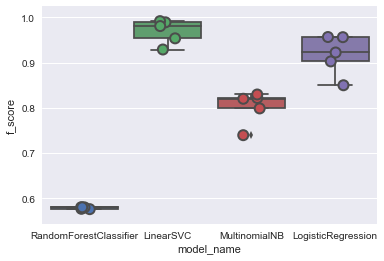

In [12]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

#cross validation scoring with macro f1 score
scorer = make_scorer(f1_score,average='micro')
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  fscores = cross_val_score(model, features, labels, scoring=scorer, cv=CV)
  for fold_idx, fscore in enumerate(fscores):
    entries.append((model_name, fold_idx, fscore))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f_score'])

sns.boxplot(x='model_name', y='f_score', data=cv_df)
sns.stripplot(x='model_name', y='f_score', data=cv_df, 
              size=10, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

#If you get n_split warning, this means there isn't enough samples for some of the classes in the data.
#See distribution plots at the bottom to check which class has few samples.

In [13]:
cv_df.groupby('model_name').f_score.mean()

model_name
LinearSVC                 0.968954
LogisticRegression        0.917625
MultinomialNB             0.801868
RandomForestClassifier    0.578268
Name: f_score, dtype: float64

## Model Evaluation
Based on above results, let's continue with LinearSVC since it got the best score.

We also calibrate the SVC model to get probability output.
Source: https://medium.com/@manoveg/multi-class-text-classification-with-probability-prediction-for-each-class-using-linearsvc-in-289189fbb100

Note: if the training set is small with respect to the number of features and classes, the reduced training set for each sub-classifier affects performance and the ensembling does not make up for it (or makes it worse). This causes SVC calibration to underperform.

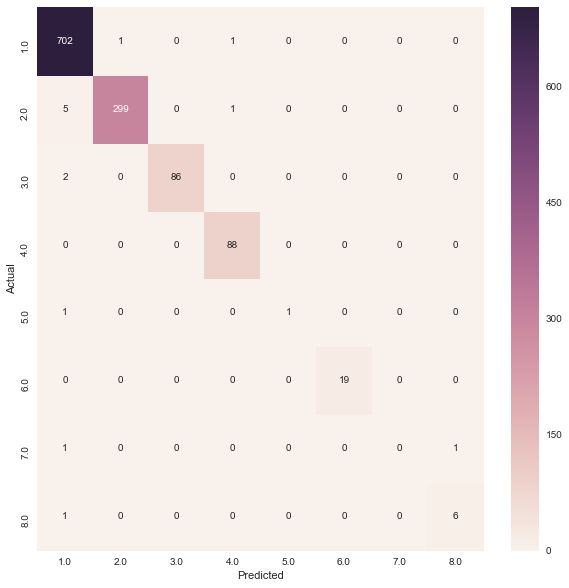

In [24]:
#train and predict
model = LinearSVC(random_state=0)
model.fit(X_train, y_train)
#y_pred = model.predict(X_test)

#calibrate the svc model to get probability output
calibrated_svc = CalibratedClassifierCV(base_estimator=model, cv="prefit")
calibrated_svc.fit(X_train, y_train)
y_pred = calibrated_svc.predict(X_test)
prob_pred = []
posterior_prob = pd.DataFrame(calibrated_svc.predict_proba(X_test)*100, columns=calibrated_svc.classes_)
for index, row in posterior_prob.iterrows():
    data = row[y_pred[index]]
    prob_pred.append(data)

#save quantity model to disk
filename = 'pickles/quantity_prediction_model.sav'
pickle.dump(model, open(filename,"wb"), protocol=2)
#save calibrated quantity model to disk
filename = 'pickles/calibrated_quantity_model.sav'
pickle.dump(calibrated_svc, open(filename,"wb"), protocol=2)
#save id to quant targets mapping dataframe to disk
filename = 'pickles/id_to_quant.pkl'
pickle.dump(id_to_quant, open(filename,"wb"), protocol=2)
#save quantity thresholds to disk
filename = 'pickles/quantity_thresholds.pkl'
pickle.dump(qty_avg_thresholds, open(filename,"wb"), protocol=2)
#save vectorizer to disk
filename = 'pickles/tfidf.pickle'
pickle.dump(tfidf, open(filename, "wb"), protocol=2)

#plot confusion matrix for Quantity prediction
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=quant_id_df.Quantity.values, yticklabels=quant_id_df.Quantity.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [25]:
#Removing predictions that fall below confidence threshold
num_of_below_threshold = 0
#y_pred = y_pred.astype(np.float32)
y_test = y_test.reset_index(drop=True)
new_y_pred = []
new_y_test = []
for index, pred in enumerate(y_pred):
    if prob_pred[index] >= qty_avg_thresholds[pred]:
        new_y_pred.append(pred)
        new_y_test.append(y_test[index])
    else:
        num_of_below_threshold += 1

display(len(y_pred))
#these two numbers should add up to the one above
display(len(new_y_pred))
display(num_of_below_threshold)
#np.isnan(y_pred).any()


1215

1188

27

In [27]:
# Calculate precision, recall, f1 for Quantity prediction before threshold
print(metrics.classification_report(y_test, y_pred, target_names=filtered_df['Quantity'].unique().astype('str')))

# Calculate precision, recall, f1 for Quantity prediction after thresholds
print(metrics.classification_report(new_y_test, new_y_pred, target_names=filtered_df['Quantity'].unique().astype('str')))

             precision    recall  f1-score   support

        1.0       0.99      1.00      0.99       704
        2.0       1.00      0.98      0.99       305
        3.0       1.00      0.98      0.99        88
        4.0       0.98      1.00      0.99        88
        5.0       1.00      0.50      0.67         2
        6.0       1.00      1.00      1.00        19
        7.0       0.00      0.00      0.00         2
        8.0       0.86      0.86      0.86         7

avg / total       0.99      0.99      0.99      1215

             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00       698
        2.0       1.00      0.99      0.99       299
        3.0       1.00      0.99      0.99        87
        4.0       1.00      1.00      1.00        86
        5.0       1.00      1.00      1.00         1
        6.0       1.00      1.00      1.00        15
        7.0       1.00      1.00      1.00         2

avg / total       1.00      1.00      1.0

/Users/tpham103/anaconda/envs/dog-project/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Features Importance Extraction

In [17]:
#using eli5 to extract features importance for quantity prediction (change labels to quant_id above before running)
eli5.show_weights(model, vec=tfidf, top=10, 
                  target_names=id_to_quant)

## Part of Text Prediction
predict which part of text most associated with frequency and quantity

In [19]:
#load prediction model
filename = "pickles/quantity_prediction_model.sav"
loaded_model = pickle.load(open(filename, 'rb'))

#load target names mapping
filename = "pickles/id_to_quant.pkl"
loaded_names = pickle.load(open(filename, 'rb'))

to_predict = "4 drops qds"

#make a prediction and show weights contributing to it
sample_prediction = eli5.explain_prediction_df(loaded_model, to_predict, vec=tfidf, 
                     target_names=loaded_names, top_targets=1)

display(sample_prediction)

,target,feature,weight,value
0,4.0,4,1.388127e+00,0.412790
1,4.0,qds,2.874036e-02,0.446551
2,4.0,drops qds,-5.718501e-19,0.659298
3,4.0,drops,-5.370660e-02,0.442180
4,4.0,<BIAS>,-8.877488e-01,1.000000


In [20]:
#highlight the part of text that correspond to prediction
highlight_text = eli5.show_prediction(loaded_model, to_predict, vec=tfidf, 
                     target_names=loaded_names, top_targets=1)

display(highlight_text)

In [21]:
#parsing the returned html for just the highlighted text
try: 
    from BeautifulSoup import BeautifulSoup
except ImportError:
    from bs4 import BeautifulSoup
    
parsed_html = BeautifulSoup(highlight_text.data, 'html.parser')
parsed_html.find('p').decompose()
parsed_html.find('table').decompose()
for p in parsed_html.find_all('p'):
    if 'style' in p.attrs:
        del p.attrs['style']

display(parsed_html)


<style>
    table.eli5-weights tr:hover {
        filter: brightness(85%);
    }
</style>


<p>
<span style="background-color: hsl(120, 100.00%, 60.00%); opacity: 1.00" title="1.388">4</span><span style="opacity: 0.80"> </span><span style="background-color: hsl(0, 100.00%, 95.89%); opacity: 0.81" title="-0.054">drops</span><span style="opacity: 0.80"> </span><span style="background-color: hsl(120, 100.00%, 97.35%); opacity: 0.80" title="0.029">qds</span>
</p>

### Getting Probability output
source: https://stackoverflow.com/questions/31617530/multiclass-linear-svm-in-python-that-return-probability

In [22]:
print('\n mapping of classes to quantity values:')
display(loaded_names)

#transform the input to grams sparse matrix
input_grams = tfidf.transform([to_predict])

#make prediction and give posterior probabilities of classification
predicted_class = calibrated_svc.predict(input_grams)[0]
predicted_value = loaded_names[predicted_class]

print('Posterior probabilities for each target class:')
pred_prob = pd.DataFrame(calibrated_svc.predict_proba(input_grams)*100, columns=calibrated_svc.classes_)
display(pred_prob)

print('\n Posterior probability of the top predicted value:')
top_prob = pred_prob[predicted_class]
display(top_prob[0])
print('Predicted value:')
display(predicted_value)


 mapping of classes to quantity values:


{0.0: 1.0,
 1.0: 2.0,
 2.0: 3.0,
 3.0: 4.0,
 4.0: 5.0,
 5.0: 6.0,
 6.0: 7.0,
 7.0: 8.0}

Posterior probabilities for each target class:


,0,1,2,3,4,5,7
0,0.031496,1.454106,0.196857,97.906028,0.291742,0.097119,0.022652



 Posterior probability of the top predicted value:


97.906027744748599

Predicted value:


4.0